### imports

In [33]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


### predict price given other features in the current timestep

#### data setup

In [35]:
area = "city of london"
monthly_data = utils.load_interpolated_data()

area_data = utils.get_area(monthly_data, area)
cols = [
    'average_price', 'year', 'month', 
    # 'average_price_d1', 
    'median_salary',
    'population_size', 'number_of_jobs', 'no_of_houses'
]  # w no nans

# cols = ['average_price', 'seconds']

In [36]:
def format_data_for_regression(area_data, cols):
    # assumes the feature to predict (i.e. price or price_d1) is the first 
    # element of cols
    y_col = cols[0]
    X_cols = cols[1:]
    train_df, test_df = train_test_split(area_data[cols + ['date']],
                                         test_size=0.3,
                                         shuffle=False)

    # normalize the data
    X_train, y_train =train_df[X_cols], train_df[y_col]
    X_test, y_test =test_df[X_cols], test_df[y_col]
    train_dates, test_dates =train_df['date'], test_df['date'] # useful for plots

    return X_train, y_train, X_test, y_test, train_dates, test_dates

In [37]:
X_train, y_train, X_test, y_test, train_dates, test_dates = format_data_for_regression(area_data, cols)

In [38]:
X_train

,year,month,median_salary,population_size,number_of_jobs,no_of_houses
0,1995,1,33020.00,6581.0,361000.000000,5009.0
1,1995,2,33020.00,6581.0,361000.000000,5009.0
2,1995,3,33020.00,6581.0,361000.000000,5009.0
3,1995,4,33020.00,6581.0,361000.000000,5009.0
4,1995,5,33020.00,6581.0,361000.000000,5009.0
...,...,...,...,...,...,...
205,2012,2,54317.50,7444.0,438166.666667,5516.0
206,2012,3,54285.75,7460.0,439250.000000,5517.5
207,2012,4,54254.00,7476.0,440333.333333,5519.0
208,2012,5,54222.25,7492.0,441416.666667,5520.5


In [39]:
y_train

0       91449
1       82203
2       79121
3       77101
4       84409
        ...  
205    510537
206    527408
207    524290
208    573532
209    542518
Name: average_price, Length: 210, dtype: int64

#### create and train model

In [40]:
lin_regression = LinearRegression()
lin_regression.fit(X_train, y_train)


LinearRegression()

In [41]:
# create model
degree =2
# is std scaler actually supposed to be after polynomial features? 
polynomial_regression = make_pipeline(PolynomialFeatures(degree=degree, include_bias=True), StandardScaler(), LinearRegression())

polynomial_regression.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

#### predictions/evaluation

Text(0.5, 1.0, 'Linear Regression Predictions')

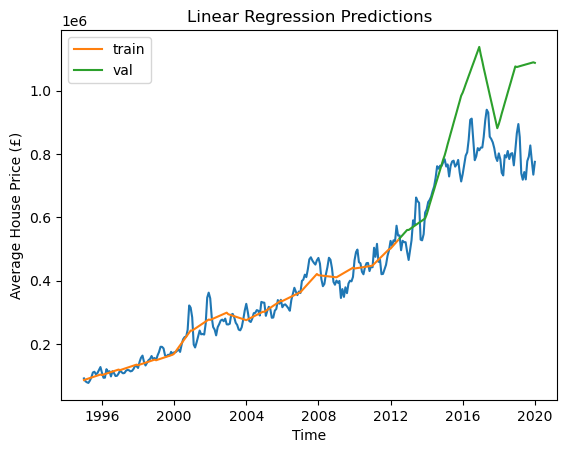

In [42]:
plt.plot(pd.concat([train_dates, test_dates]), pd.concat([y_train, y_test]))
plt.plot(train_dates, lin_regression.predict(X_train), label='train')
plt.plot(test_dates, lin_regression.predict(X_test), label='val')
plt.legend()
plt.ylabel(u'Average House Price (\xA3)')
plt.xlabel('Time')
plt.title('Linear Regression Predictions')

Text(0.5, 1.0, 'Deg. 2 Polynomial Regression Predictions')

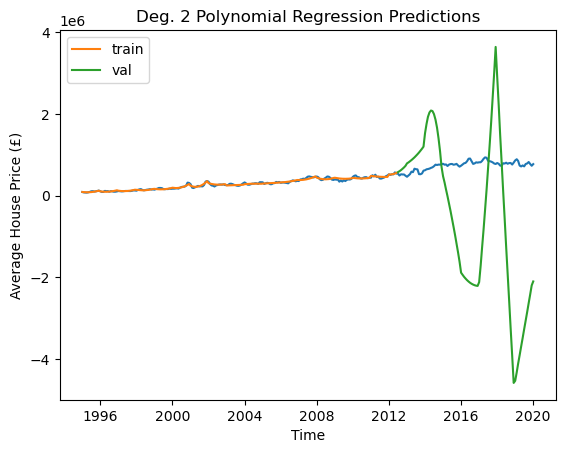

In [43]:
plt.plot(pd.concat([train_dates, test_dates]), pd.concat([y_train, y_test]))
plt.plot(train_dates, polynomial_regression.predict(X_train), label='train')
plt.plot(test_dates, polynomial_regression.predict(X_test), label='val')
plt.legend()
plt.ylabel(u'Average House Price (\xA3)')
plt.xlabel('Time')
plt.title(f'Deg. {degree} Polynomial Regression Predictions')

### forecast into the future

#### data

In [44]:
lookback=12
lookforward=12

train_df, test_df, X_train, y_train, X_test, y_test, scaler = utils.format_data_for_forecasting(area_data, cols, lookback, lookforward)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1] * y_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1] * y_test.shape[2]))


In [45]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 84)
(186, 84)
(67, 84)
(67, 84)


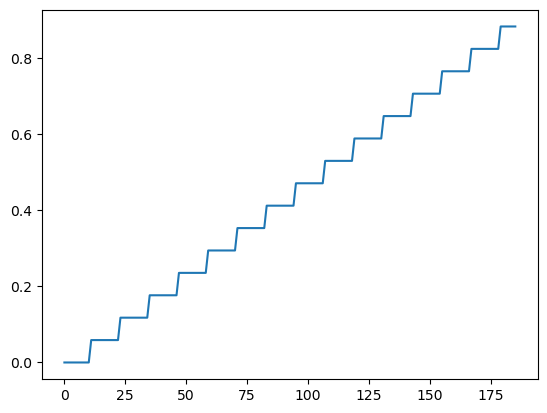

In [46]:
plt.plot(X_train[:, 8])
# so the second index % 8 indicates the feature
# and the second index // 8 indicates the timestep forward or backward of the feature


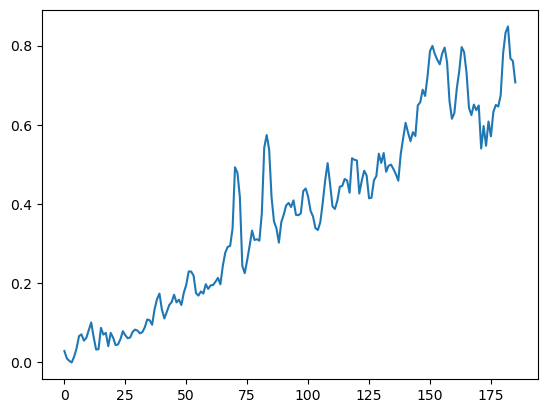

In [47]:
plt.plot(X_train[:, 0])


#### create and train model

In [48]:
lin_regression = LinearRegression()
lin_regression.fit(X_train, y_train)


LinearRegression()

In [49]:
# create model
degree =2
# is std scaler actually supposed to be after polynomial features? 
polynomial_regression = make_pipeline(PolynomialFeatures(degree=degree, include_bias=True), StandardScaler(), LinearRegression())

polynomial_regression.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

#### predictions/evaluation

In [50]:
pred_train = lin_regression.predict(X_train)
pred_test = lin_regression.predict(X_test)

# recover original shape
# i.e. (n_samples, n_timesteps, n_features)
pred_train = pred_train.reshape(pred_train.shape[0], lookforward, len(cols))
pred_test = pred_test.reshape(pred_test.shape[0], lookforward, len(cols))

# revert scaling 
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


In [51]:
def plot_inputs_outputs(area_data,
                        ground_truth,
                        train_ts,
                        test_ts,
                        cols,
                        col_idx,
                        lookback,
                        lookforward,
                        fwd_offset,
                        title=''):
    """ Args: 
            area_data: dataframe containing dates
            ground_truth: dataframe containing ground truth data
            train_ts: np array containing time series in the shape 
                (n_samples, lookback timesteps, n_features)
            test_ts: np array containing time series in the shape 
                (n_samples, lookforward timesteps, n_features)
            cols (str list): list of strings of features 
            col_idx (int): index of the feature to be plotted 
            lookback (int): number of timesteps in the lookback 
            lookforward (int): number of timesteps in the lookforward
            fwd_idx (int): which forward prediction/sample to plot
            title (str)
    """
    # fwd_idx = fwd_idx % lookforward
    col = cols[col_idx]
    plt.plot(area_data.date, ground_truth[col])
    plt.plot(area_data.date[range(lookback, lookback + len(train_ts))],
             train_ts[:, col_idx], label='train')
    plt.plot(
        area_data.date[range(
            lookback * 2 + fwd_offset + lookforward + len(train_ts),
            lookback * 2 + fwd_offset + lookforward + len(train_ts) +
            len(test_ts))], test_ts[:, col_idx], label='val')
    
    plt.ylabel(u'Average House Price (\xA3)')
    plt.xlabel('Time')
    plt.legend()
    plt.title(title)

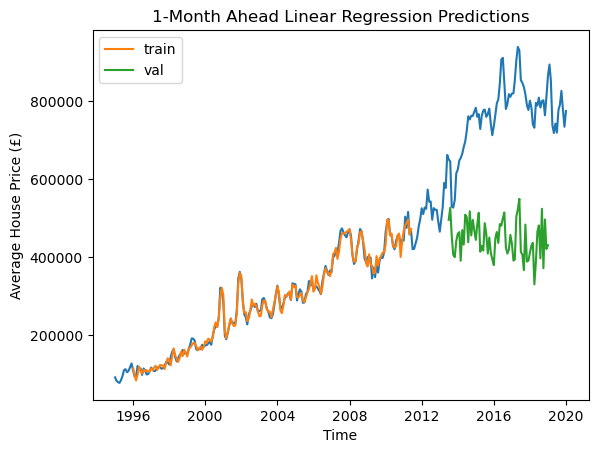

In [52]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-Month Ahead Linear Regression Predictions')


In [53]:
# recover original shape
# i.e. (n_samples, n_timesteps, n_features)
y_train = y_train.reshape(y_train.shape[0], lookforward, len(cols))
y_test = y_test.reshape(y_test.shape[0], lookforward, len(cols))

# revert scaling 
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])
y_12mo_train_rescaled = scaler.inverse_transform(y_train[:, -1])
y_12mo_test_rescaled = scaler.inverse_transform(y_test[:, -1])


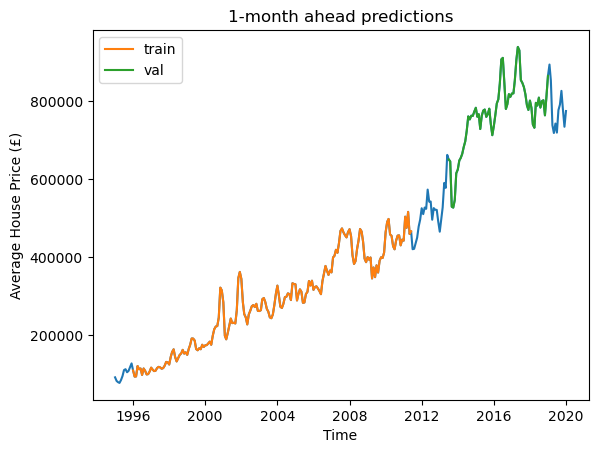

In [57]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_1mo_train_rescaled,
                    test_ts=y_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')


compute RMSE

In [60]:
print('Train 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_train_rescaled[:, 0],
                           y_1mo_train_rescaled[:, 0]))))
print('Test 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_test_rescaled[:, 0],
                           y_1mo_test_rescaled[:, 0]))))

print('Train 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_train_rescaled[:, 0],
                           y_12mo_train_rescaled[:, 0]))))
print('Test 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_test_rescaled[:, 0],
                           y_12mo_test_rescaled[:, 0]))))


Train 1mo RMSE: 10646.29251531786
Test 1mo RMSE: 334246.59802153317
Train 12mo RMSE: 28224.236927961225
Test 12mo RMSE: 1072242.0119109717


(186, 1)

Train 1mo RMSE: 43145.30046275838
Test 1mo RMSE: 151942.63424087098
Train 12mo RMSE: 43791.2958696926
Test 12mo RMSE: 127597.74988532721


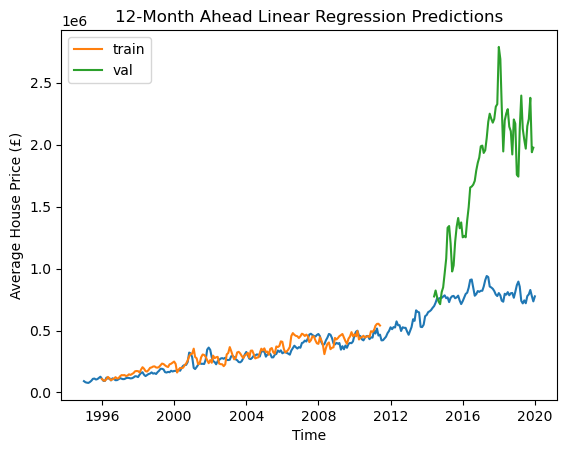

In [21]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title='12-Month Ahead Linear Regression Predictions')


In [22]:
pred_train = polynomial_regression.predict(X_train)
pred_test = polynomial_regression.predict(X_test)

# recover original shape
# i.e. (n_samples, n_timesteps, n_features)
pred_train = pred_train.reshape(pred_train.shape[0], lookforward, len(cols))
pred_test = pred_test.reshape(pred_test.shape[0], lookforward, len(cols))

# revert scaling 
# train_df[cols] = scaler.inverse_transform(train_df[cols])
# test_df[cols] = scaler.inverse_transform(test_df[cols])

pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


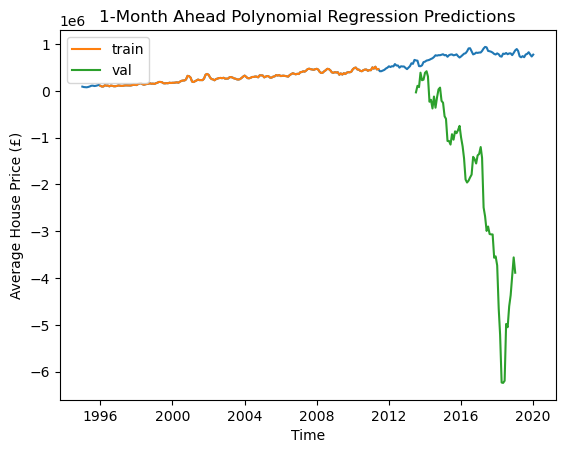

In [23]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-Month Ahead Polynomial Regression Predictions')


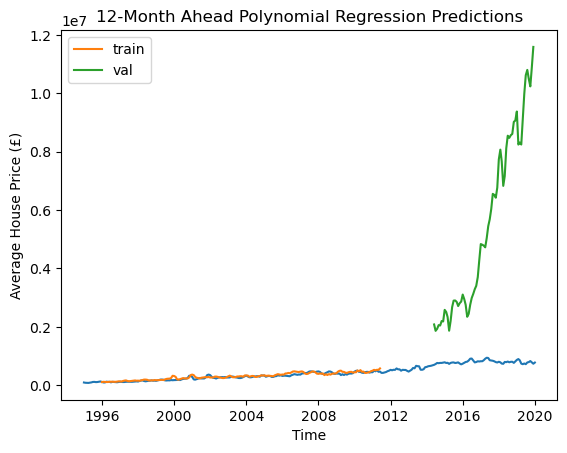

In [24]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title='12-Month Ahead Polynomial Regression Predictions')
